In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

c:\Python311\Lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Rutas de las carpetas de entrenamiento, predicción y test
training_path = 'training'
test_path = 'test'
prediction_path = 'prediction'

In [3]:
# Aumentación de datos
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)

Found 14034 images belonging to 6 classes.


<Figure size 640x480 with 0 Axes>

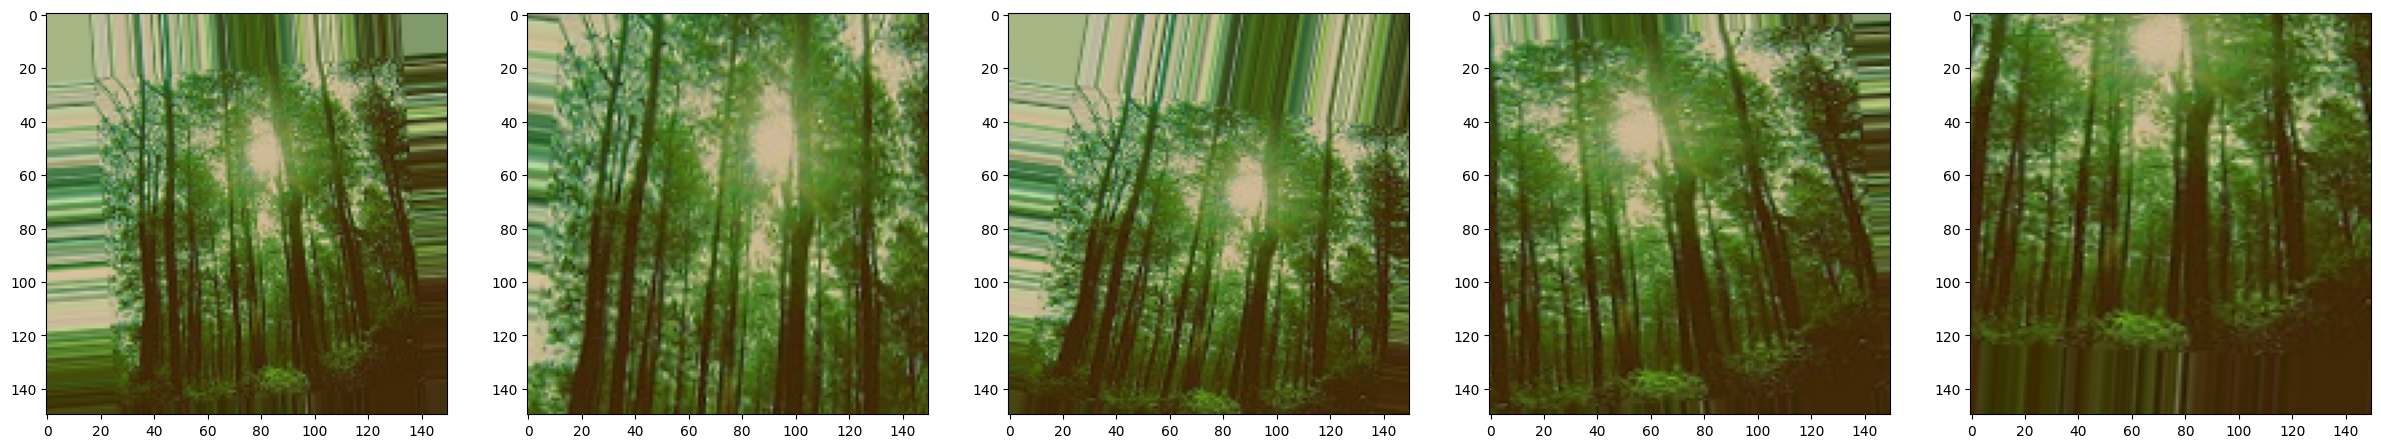

In [4]:
# Crear generadores de datos a partir de los directorios de entrenamiento y prueba
train_generator = datagen.flow_from_directory(
    training_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Crear un plt para mostrar las imágenes
plt.figure()
f, axarr = plt.subplots(1, 5, figsize=(30, 8))

# Iterar sobre las primeras 5 imágenes del generador y mostrarlas
for i in range(5) :
  axarr[i].imshow(train_generator[0][0][0])

Found 14034 images belonging to 6 classes.
(8, 150, 150, 3)
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]]


<Figure size 640x480 with 0 Axes>

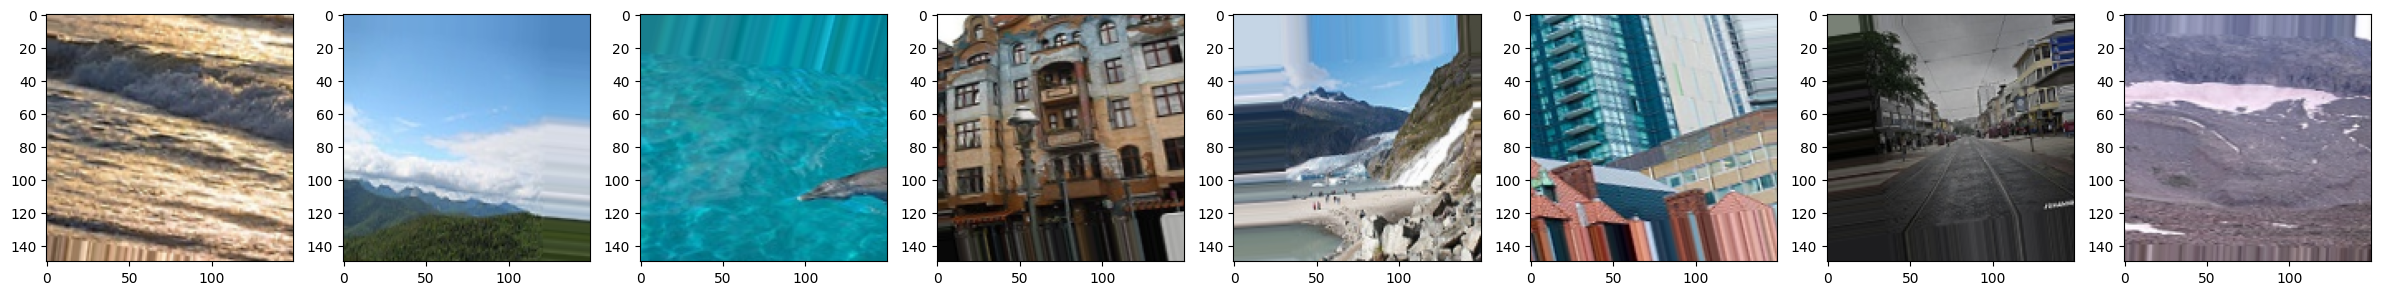

In [5]:
# Crear un generador de datos a partir de un directorio de entrenamiento
train_generator = datagen.flow_from_directory(
    training_path,
    target_size=(150, 150),
    batch_size=8,
    class_mode='categorical'
)

images, labels = next(train_generator)

print(images.shape)
print(labels)
plt.figure()
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4))

for i in range(images.shape[0]):
    axarr[i].imshow(images[i])

# Mostrar las imágenes del principio
plt.show()

In [6]:
# Crear un generador de datos a partir de un directorio de test
test_generator = datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Crear un generador de datos a partir de un directorio de entrenamiento
train_generator = datagen.flow_from_directory(
    training_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 3000 images belonging to 6 classes.


In [7]:
# Cargar el modelo ResNet50 pre-entrenado sin la capa superior (include_top=False)
base_model = ResNet50(weights='imagenet', include_top=False)

# Agregar una capa GlobalAveragePooling2D y una capa Dense para la clasificación
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(6, activation='softmax')(x)

In [8]:
# Definir el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Congelar todas las capas de la base ResNet50
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator
)

Epoch 1/10


c:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1755/1755 ━━━━━━━━━━━━━━━━━━━━ 258s 145ms/step - accuracy: 0.2808 - loss: 1.6930 - val_accuracy: 0.3883 - val_loss: 1.4796
Epoch 2/10
1755/1755 ━━━━━━━━━━━━━━━━━━━━ 252s 143ms/step - accuracy: 0.4314 - loss: 1.4566 - val_accuracy: 0.4550 - val_loss: 1.3757
Epoch 3/10
1755/1755 ━━━━━━━━━━━━━━━━━━━━ 250s 142ms/step - accuracy: 0.4712 - loss: 1.3656 - val_accuracy: 0.4913 - val_loss: 1.3072
Epoch 4/10
1755/1755 ━━━━━━━━━━━━━━━━━━━━ 251s 143ms/step - accuracy: 0.4897 - loss: 1.3103 - val_accuracy: 0.4753 - val_loss: 1.2931
Epoch 5/10
1755/1755 ━━━━━━━━━━━━━━━━━━━━ 251s 143ms/step - accuracy: 0.4934 - loss: 1.2853 - val_accuracy: 0.4813 - val_loss: 1.2611
Epoch 6/10
1755/1755 ━━━━━━━━━━━━━━━━━━━━ 251s 143ms/step - accuracy: 0.5231 - loss: 1.2370 - val_accuracy: 0.5360 - val_loss: 1.2196
Epoch 7/10
1755/1755 ━━━━━━━━━━━━━━━━━━━━ 251s 143ms/step - accuracy: 0.5221 - loss: 1.2233 - val_accuracy: 0.4783 - val_loss: 1.2425
Epoch 8/10
1755/1755 ━━━━━━━━━━━━━━━━━━━━ 251s 143ms/step - accuracy: 0.5

94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 423ms/step - accuracy: 0.5547 - loss: 1.1551

Test accuracy: 0.5509999990463257


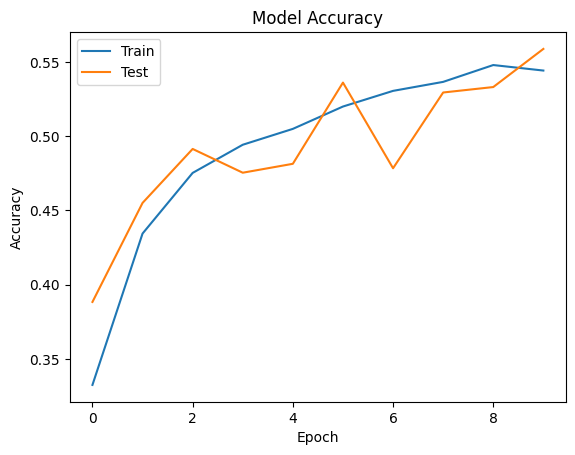

In [9]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print('\nTest accuracy:', test_acc)

# Mostrar las curvas de aprendizaje
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Mostrar las curvas de pérdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()